In [1]:
%pip install transformer_lens

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformer_lens import HookedEncoderDecoder
import transformer_lens.utils as utils
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformer_lens.loading_from_pretrained import OFFICIAL_MODEL_NAMES

import torch

torch.set_grad_enabled(False)


In [3]:
torch.cuda.is_available()

False

## Loading the Model in TransformerLens

Please download the model first: https://cloud.anja.re/s/Qpo8CZ6yRzDH7ZF

In [4]:
checkpoint = "./DSI-large-7423/DSI-large-7423"

OFFICIAL_MODEL_NAMES.append(checkpoint)

hf_model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
device = utils.get_device()
model = HookedEncoderDecoder.from_pretrained(checkpoint, hf_model=hf_model, device=device)

tokenizer_t5 = AutoTokenizer.from_pretrained('google-t5/t5-large')


# Our model has a new token for each document id that we trained it on.

# token id of first document that was added
first_added_doc_id = len(tokenizer_t5)
# token id of the last document that was added
last_added_doc_id = len(tokenizer_t5) + (len(tokenizer) - len(tokenizer_t5))
del tokenizer_t5


If using T5 for interpretability research, keep in mind that T5 has some significant architectural differences to GPT. The major one is that T5 is an Encoder-Decoder modelAlso, it uses relative positional embeddings, different types of Attention (without bias) and LayerNorm


Loaded pretrained model ./DSI-large-7423/DSI-large-7423 into HookedTransformer


In [5]:
print("UNK token:", tokenizer.unk_token)
print("UNK token ID:", tokenizer.unk_token_id)


UNK token: <unk>
UNK token ID: 2


## Running a sample query

In [6]:
query = "test query"

input_tokens = tokenizer(query, return_tensors='pt')['input_ids']
decoder_input = torch.tensor([[0]])

logits, cache = model.run_with_cache(input_tokens, decoder_input, remove_batch_dim=True)

In [7]:
query = "which team did michael jordan played in in 1996?"

input_tokens = tokenizer(query, return_tensors='pt')['input_ids']
decoder_input = torch.tensor([[0]])

logits, cache = model.run_with_cache(input_tokens, decoder_input, remove_batch_dim=True)

In [8]:
logits

tensor([[[-141.2259, -102.9913,  -91.2619,  ...,   -8.2854,   -9.3236,
            -8.0200]]])

In [9]:
# Prediction from the logits
torch.argmax(logits, dim=-1), tokenizer.decode(torch.argmax(logits, dim=-1)[0][0])

(tensor([[38706]]), '@DOC_ID_378327914117624271@')

## Examining the activations

The activations of each component in the transformer are stored in the `cache` object. It's basically a dict from which you choose which component to look at.

Here, we print all possible component keys for layer 0 in the decoder:

In [10]:
for key in cache.keys():
  if key.startswith('decoder.'):
    print(key)

decoder.0.hook_resid_pre
decoder.0.ln1.hook_scale
decoder.0.ln1.hook_normalized
decoder.0.attn.hook_q
decoder.0.attn.hook_k
decoder.0.attn.hook_v
decoder.0.attn.hook_attn_scores
decoder.0.attn.hook_pattern
decoder.0.attn.hook_z
decoder.0.hook_attn_out
decoder.0.hook_resid_mid
decoder.0.ln2.hook_scale
decoder.0.ln2.hook_normalized
decoder.0.cross_attn.hook_q
decoder.0.cross_attn.hook_k
decoder.0.cross_attn.hook_v
decoder.0.cross_attn.hook_attn_scores
decoder.0.cross_attn.hook_pattern
decoder.0.cross_attn.hook_z
decoder.0.hook_cross_attn_out
decoder.0.hook_resid_mid_cross
decoder.0.ln3.hook_scale
decoder.0.ln3.hook_normalized
decoder.0.mlp.hook_pre
decoder.0.mlp.hook_post
decoder.0.hook_mlp_out
decoder.0.hook_resid_post
decoder.1.hook_resid_pre
decoder.1.ln1.hook_scale
decoder.1.ln1.hook_normalized
decoder.1.attn.hook_q
decoder.1.attn.hook_k
decoder.1.attn.hook_v
decoder.1.attn.hook_attn_scores
decoder.1.attn.hook_pattern
decoder.1.attn.hook_z
decoder.1.hook_attn_out
decoder.1.hook_resid

In [11]:
# Large, diverse query set for neuron activation experiments in GenIR

topic_to_query_list = {
    "sports": [
        "who won the gold medal in 100m sprint",
        "final score of the Super Bowl 2021",
        "who is the top scorer in the NBA this season",
        "results of the Wimbledon 2020",
        "which country hosted the FIFA World Cup 2014",
        "best Olympic performances in swimming",
        "who won the Tour de France in 2022",
        "record holders in pole vault",
        "results of the UEFA Champions League 2023",
        "medal tally of Tokyo Olympics",
        "most goals in a single World Cup match",
        "schedule of the 2024 Summer Olympics",
        "famous tennis rivalries in history",
        "MVPs in NBA Finals by year",
        "world record in women's marathon"
    ],
    
    "literature": [
        "who wrote To Kill a Mockingbird",
        "plot summary of 1984 by George Orwell",
        "books written by Agatha Christie",
        "themes in The Great Gatsby",
        "awards won by J.K. Rowling",
        "famous quotes from Shakespeare plays",
        "what is the main theme of Animal Farm",
        "literary works by Leo Tolstoy",
        "biography of Jane Austen",
        "characters in Pride and Prejudice",
        "summary of Moby Dick",
        "who is the narrator of The Catcher in the Rye",
        "genres explored by Stephen King",
        "origin of the epic Beowulf",
        "difference between modernism and postmodernism in literature"
    ],
    
    "history": [
        "causes of World War I",
        "when did the Berlin Wall fall",
        "leaders of the French Revolution",
        "important events in American Civil War",
        "dates of Roman Empire emperors",
        "outcome of the Cuban Missile Crisis",
        "main battles in the Napoleonic Wars",
        "timeline of the Cold War",
        "effects of the Industrial Revolution",
        "treaties signed after World War II",
        "fall of the Ottoman Empire",
        "significance of the Magna Carta",
        "role of Martin Luther King Jr. in civil rights movement",
        "who discovered the Americas",
        "collapse of the Soviet Union"
    ],
    
    "geography": [
        "highest mountain in South America",
        "population of Tokyo in 2020",
        "countries that border Germany",
        "capital city of Australia",
        "rivers flowing through Paris",
        "climate zones of Africa",
        "longest rivers in North America",
        "where is the Great Barrier Reef located",
        "natural resources found in Canada",
        "what deserts are in Asia",
        "geographical features of Iceland",
        "time zones across Russia",
        "largest lakes in the world",
        "volcanoes located along the Ring of Fire",
        "difference between tundra and taiga biomes"
    ],
    
    "entertainment": [
        "cast of the movie Inception",
        "who won the Oscar for Best Actor in 2020",
        "top-grossing films of all time",
        "director of The Godfather trilogy",
        "netflix shows released in 2022",
        "theme song of Game of Thrones",
        "when was the first Star Wars movie released",
        "who played Harry Potter in the movies",
        "Golden Globe winners in 2023",
        "upcoming Marvel Cinematic Universe releases",
        "famous Disney animated films from the 1990s",
        "box office performance of Avatar: The Way of Water",
        "musicians with the most Grammy wins",
        "release date of Stranger Things Season 5",
        "theme music composer for Interstellar"
    ]
}


In [12]:
import torch
from collections import defaultdict

# Configure experiment parameters
NUM_LAYERS = 24
LAST_N_LAYERS = 6
TOP_K = 20
layers_to_check = list(range(NUM_LAYERS - LAST_N_LAYERS, NUM_LAYERS))

# Storage for results
top_neuron_stats = defaultdict(lambda: defaultdict(list))

for topic, queries in topic_to_query_list.items():
    print(f"\n=== Processing topic: {topic} ===")
    for query in queries[:3]:  # Only 3 queries per topic to avoid OOM
        input_tokens = tokenizer(query, return_tensors='pt')['input_ids']
        decoder_input = torch.tensor([[0]])
        
        with torch.no_grad():
            logits, cache = model.run_with_cache(input_tokens, decoder_input, remove_batch_dim=True)

        for layer in layers_to_check:
            hook_name = f"decoder.{layer}.hook_mlp_out"
            if hook_name not in cache:
                print(f"Missing: {hook_name}")
                continue
            mlp_out = cache[hook_name]  # shape: [seq, d_model]
            neuron_activity = mlp_out.abs().mean(dim=0)
            top_neurons = torch.topk(neuron_activity, TOP_K).indices.tolist()
            top_neuron_stats[topic][layer].extend(top_neurons)

# Aggregate counts
for topic in top_neuron_stats:
    print(f"\n=== Summary for Topic: {topic} ===")
    for layer in top_neuron_stats[topic]:
        counts = defaultdict(int)
        for idx in top_neuron_stats[topic][layer]:
            counts[idx] += 1
        top_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]
        print(f"  Layer {layer}:")
        for neuron, freq in top_counts:
            print(f"    Neuron {neuron} - appeared {freq} times in top-{TOP_K}")



=== Processing topic: sports ===



=== Processing topic: literature ===



=== Processing topic: history ===



=== Processing topic: geography ===



=== Processing topic: entertainment ===



=== Summary for Topic: sports ===
  Layer 18:
    Neuron 679 - appeared 3 times in top-20
    Neuron 278 - appeared 2 times in top-20
    Neuron 589 - appeared 2 times in top-20
    Neuron 218 - appeared 2 times in top-20
    Neuron 834 - appeared 2 times in top-20
    Neuron 271 - appeared 1 times in top-20
    Neuron 499 - appeared 1 times in top-20
    Neuron 526 - appeared 1 times in top-20
    Neuron 46 - appeared 1 times in top-20
    Neuron 1007 - appeared 1 times in top-20
  Layer 19:
    Neuron 589 - appeared 3 times in top-20
    Neuron 834 - appeared 3 times in top-20
    Neuron 499 - appeared 3 times in top-20
    Neuron 29 - appeared 3 times in top-20
    Neuron 537 - appeared 2 times in top-20
    Neuron 503 - appeared 2 times in top-20
    Neuron 679 - appeared 1 times in top-20
    Neuron 238 - appeared 1 times in top-20
    Neuron 705 - appeared 1 times in top-20
    Neuron 473 - appeared 1 times in top-20
  Layer 20:
    Neuron 499 - appeared 3 times in top-20
    Ne


📊 Layer 18:


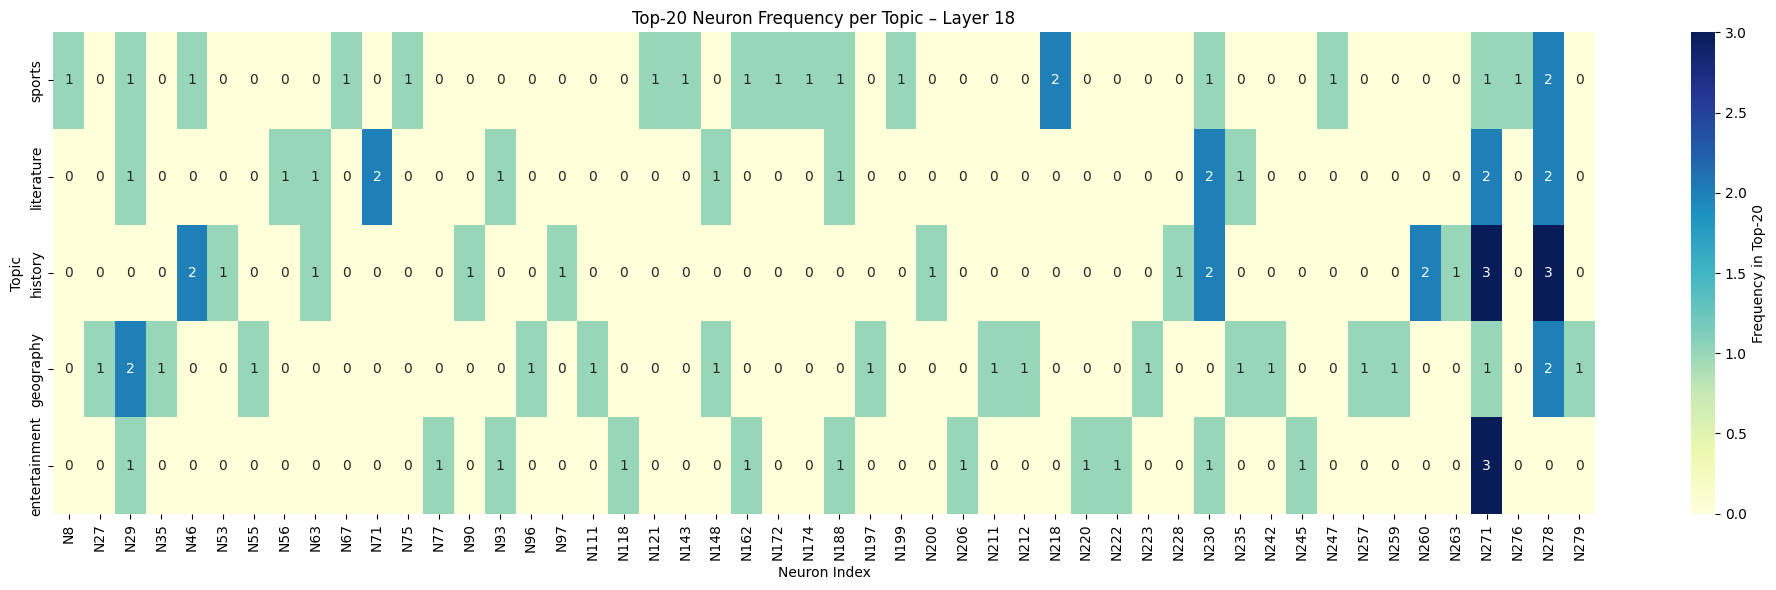


📊 Layer 19:


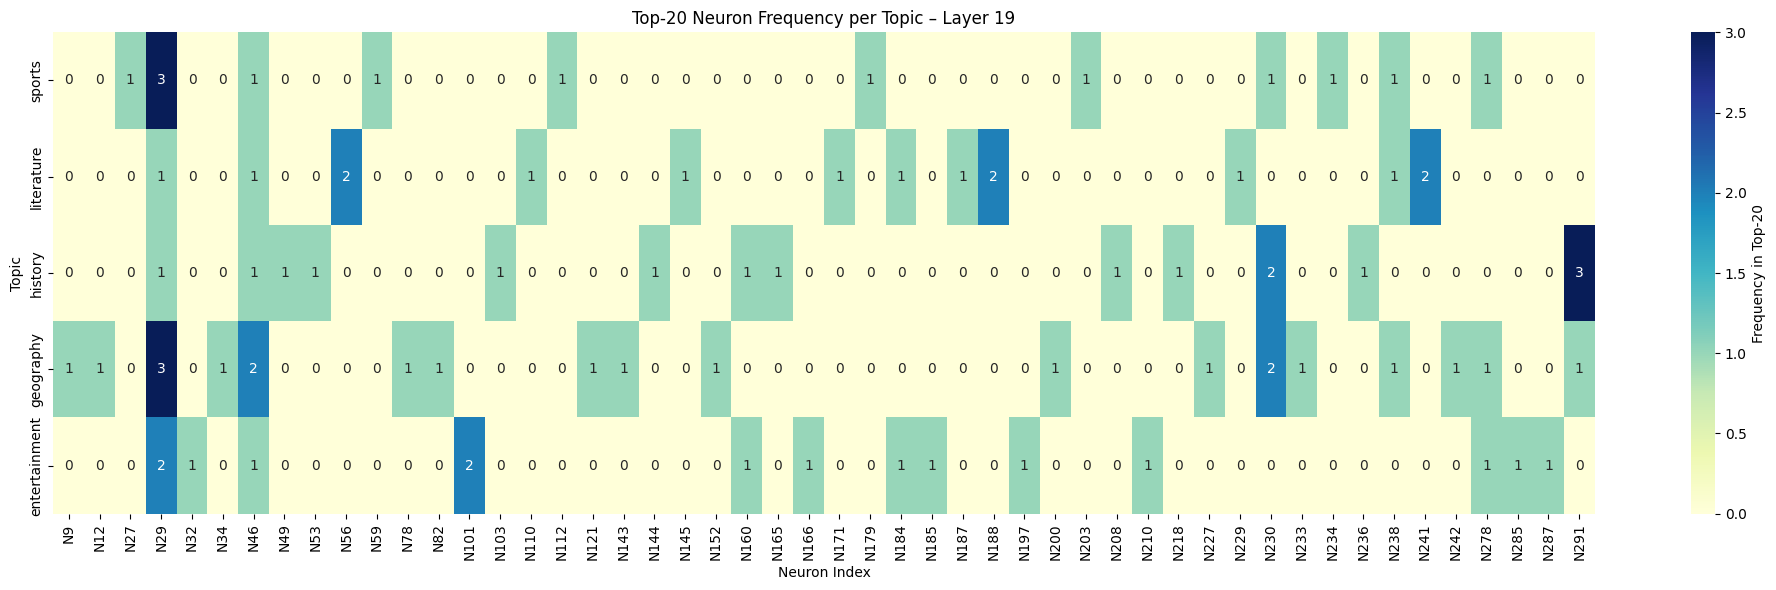


📊 Layer 20:


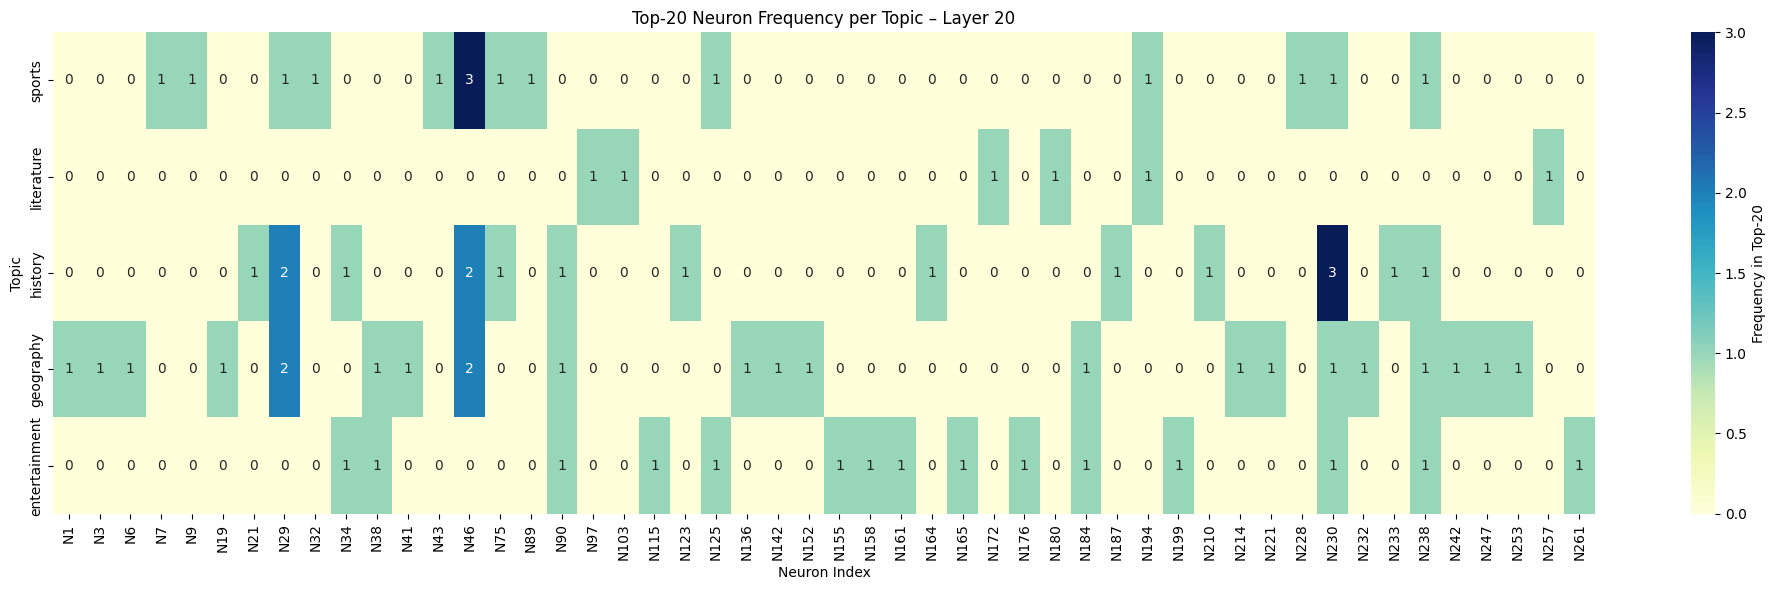


📊 Layer 21:


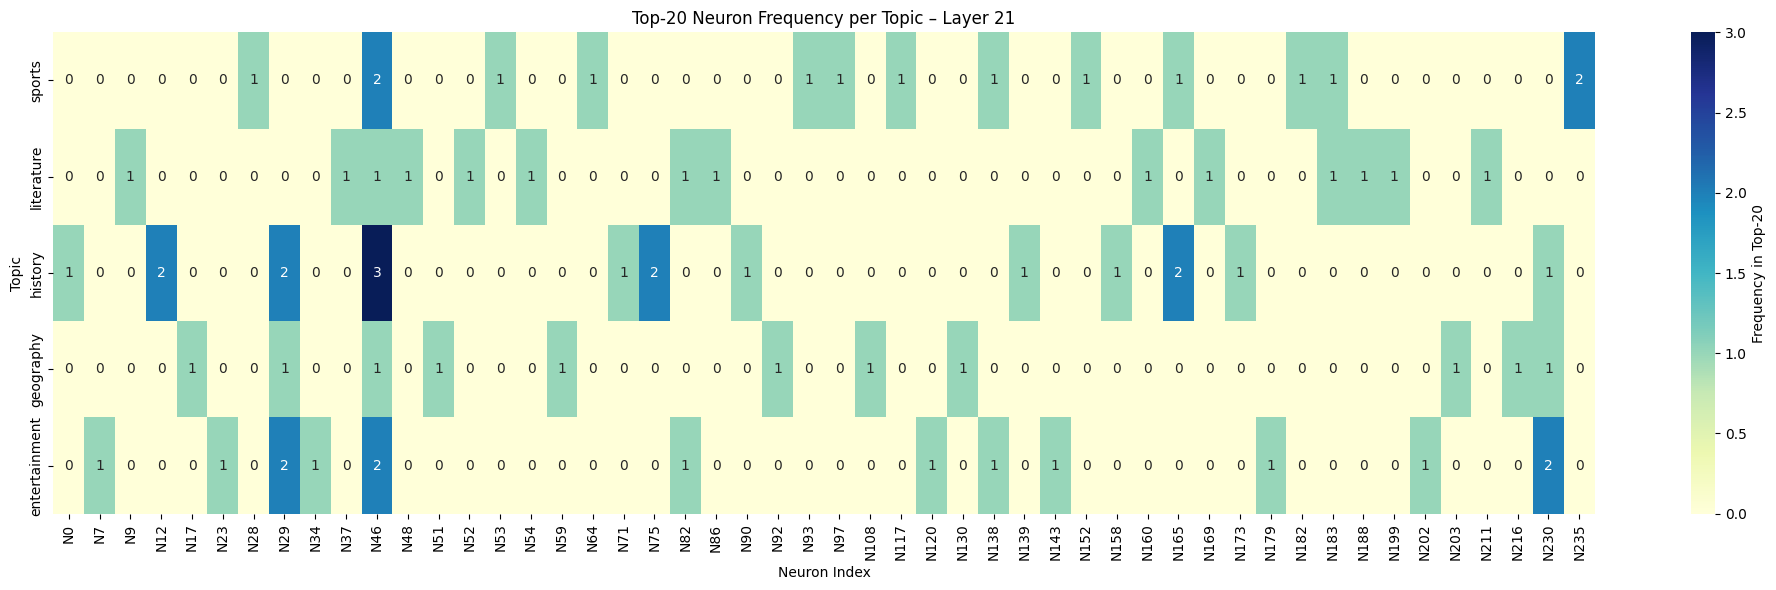


📊 Layer 22:


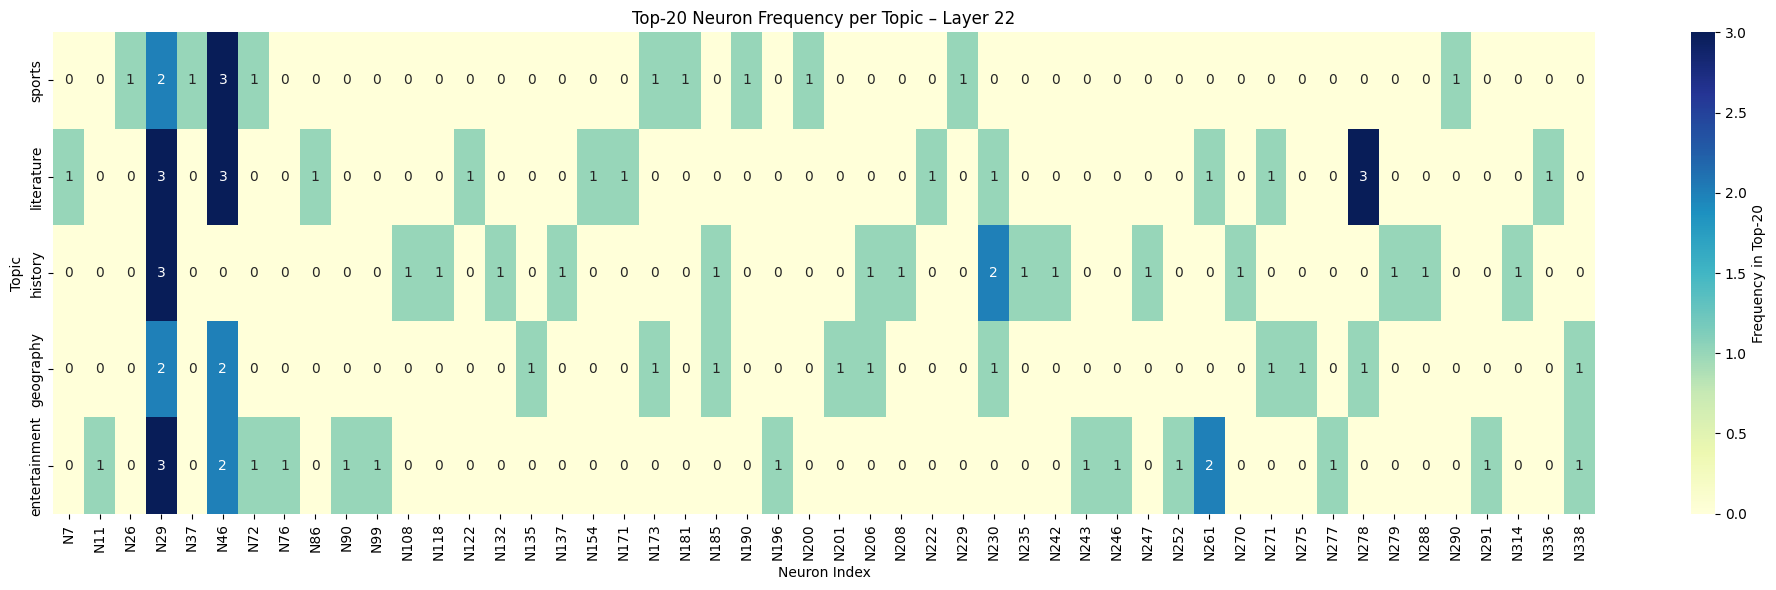


📊 Layer 23:


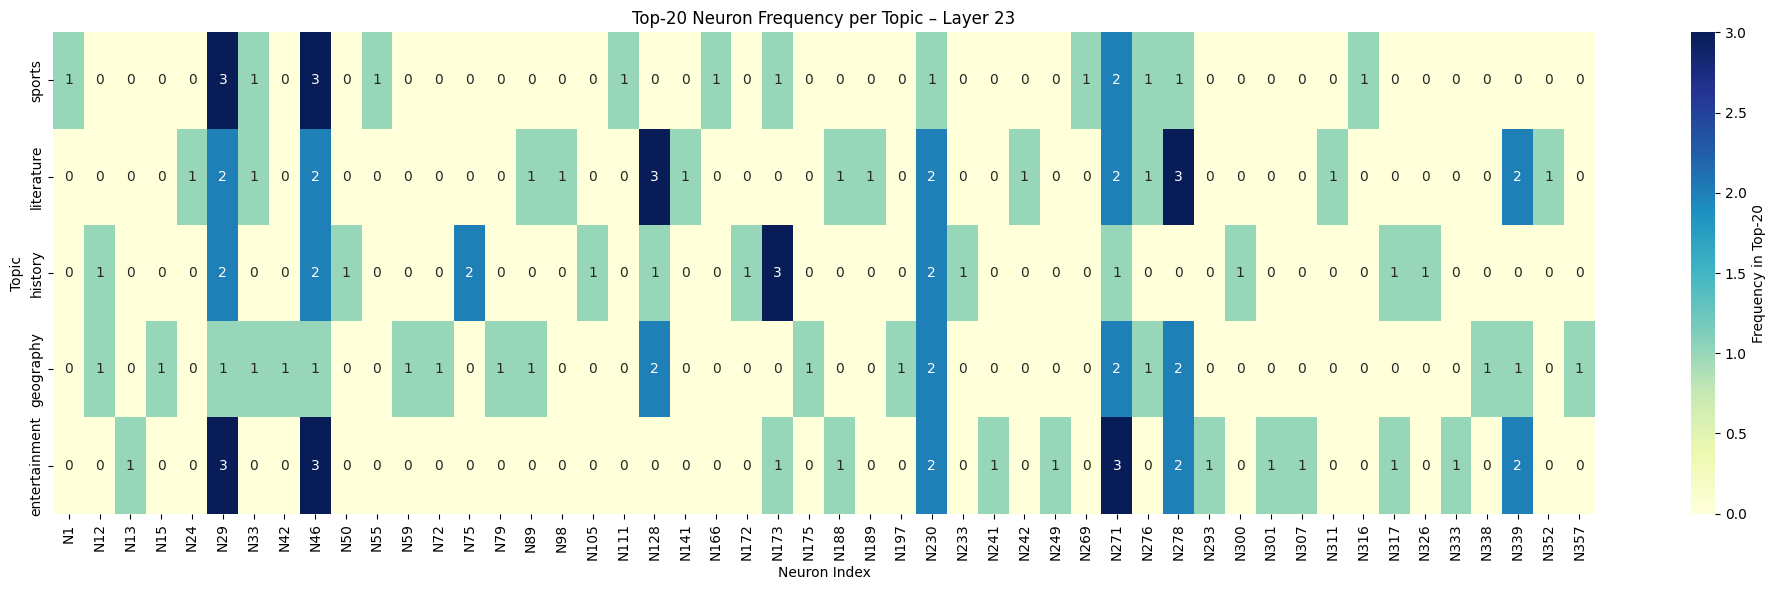

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_neuron_heatmaps(top_neuron_stats, top_k=20, layers_to_plot=None, max_neurons=50):
    if layers_to_plot is None:
        layers_to_plot = sorted(top_neuron_stats[list(top_neuron_stats.keys())[0]].keys())

    for layer in layers_to_plot:
        print(f"\n📊 Layer {layer}:")

        # Build a DataFrame: rows = topics, columns = neuron IDs
        all_neurons = set()
        for topic in top_neuron_stats:
            all_neurons.update(top_neuron_stats[topic][layer])
        all_neurons = sorted(all_neurons)[:max_neurons]

        data = []
        for topic in top_neuron_stats:
            counts = pd.Series(top_neuron_stats[topic][layer]).value_counts()
            row = [counts.get(nid, 0) for nid in all_neurons]
            data.append(row)

        df = pd.DataFrame(data, columns=[f"N{n}" for n in all_neurons], index=top_neuron_stats.keys())

        # Plot heatmap
        plt.figure(figsize=(min(0.5*len(all_neurons)+5, 20), 6))
        sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': f'Frequency in Top-{top_k}'})
        plt.title(f"Top-{top_k} Neuron Frequency per Topic – Layer {layer}")
        plt.xlabel("Neuron Index")
        plt.ylabel("Topic")
        plt.tight_layout()
        plt.show()

# Call the plotting function
plot_top_neuron_heatmaps(top_neuron_stats, top_k=TOP_K, layers_to_plot=layers_to_check)


In [14]:
import torch

# Set target layer and neuron
target_layer = 23
target_neuron_idx = -2
hook_name = f"decoder.{target_layer}.mlp.hook_post"

# Get UNK token id
unk_token_id = tokenizer.unk_token_id
if unk_token_id is None:
    # Some tokenizers don't define unk_token_id; try to find it manually
    unk_token_id = tokenizer.convert_tokens_to_ids(['<unk>'])[0]

query = "what year did michael phillips won gold medal?"
query_default = "test query"

input_tokens = tokenizer(query, return_tensors='pt')['input_ids']
decoder_input = torch.tensor([[0]])

# Original forward pass to get baseline activation
logits, cache = model.run_with_cache(input_tokens, decoder_input, remove_batch_dim=True)
mlp_out = cache[hook_name]
original_activation = mlp_out[:, target_neuron_idx].sum().item()

tokens = input_tokens.clone()  # clone to avoid modifying original
seq_len = tokens.shape[1]

token_impacts = []

for i in range(seq_len):
    ablated_tokens = tokens.clone()
    ablated_tokens[0, i] = unk_token_id  # replace token i with UNK
    
    # Forward pass with ablated input
    logits_ablated, cache_ablated = model.run_with_cache(ablated_tokens, decoder_input, remove_batch_dim=True)
    mlp_out_ablated = cache_ablated[hook_name]
    ablated_activation = mlp_out_ablated[:, target_neuron_idx].sum().item()
    
    impact = original_activation - ablated_activation
    token_impacts.append(impact)

# Normalize impacts for better visualization
impacts_tensor = torch.abs(torch.tensor(token_impacts))
impacts_tensor /= (impacts_tensor.max() + 1e-10)

token_strs = tokenizer.convert_ids_to_tokens(tokens[0])
print(f"\nNeuron-to-Token Ablation Attribution (using UNK token) - Layer {target_layer}, Neuron {target_neuron_idx}:")
for tok, impact in zip(token_strs, impacts_tensor):
    print(f"{tok:<15} -> impact: {impact.item():.4f}")



Neuron-to-Token Ablation Attribution (using UNK token) - Layer 23, Neuron -2:
▁what           -> impact: 0.0000
▁year           -> impact: 0.0000
▁did            -> impact: 0.0000
▁mich           -> impact: 0.0000
a               -> impact: 0.0000
e               -> impact: 0.0000
l               -> impact: 0.0000
▁               -> impact: 0.0000
phil            -> impact: 0.0000
lip             -> impact: 0.0000
s               -> impact: 0.0000
▁won            -> impact: 0.0000
▁gold           -> impact: 0.0000
▁medal          -> impact: 0.0000
?               -> impact: 0.0000
</s>            -> impact: 0.0000


In [15]:
categories = {
    "news": [
        "latest news about the elections",
        "breaking news in technology today",
        "global news headlines from this week",
        "news coverage of the climate summit",
        "economic news affecting markets",
        "local updated news about the war in Israel"
    ],

    "year": [
        "what happened in the year 1990",
        "films released in the year 2000",
        "Olympic winners in the year 2012",
        "political events in the year 1989",
        "top books published in the year 2020"
    ],

    "today": [
        "what are the top stories today",
        "weather forecast for today",
        "stock market news today",
        "football matches scheduled for today",
        "any holidays celebrated today"
    ],

    "yesterday": [
        "news highlights from yesterday",
        "sports results from yesterday",
        "what happened yesterday in parliament",
        "earthquake reported yesterday",
        "TV shows aired yesterday"
    ],

    "not": [
        "why is the vaccine not effective",
        "this product is not working properly",
        "the data was not updated",
        "not all players were present",
        "he did not finish the race"
    ],

    "great": [
        "what made the book so great",
        "the great wall of China length",
        "great performances in Olympic history",
        "who were the great scientists of the 20th century",
        "great inventions of the industrial age"
    ],

    "who": [
        "who discovered penicillin",
        "who is the CEO of Tesla",
        "who won the Nobel Peace Prize in 2020",
        "who invented the light bulb",
        "who directed Inception"
    ],

    "new": [
        "new policies introduced this year",
        "what are the new features in iOS",
        "launch of the new iPhone",
        "new trends in artificial intelligence",
        "new laws passed by Congress"
    ],

    "best": [
        "best restaurants in New York",
        "who is the best chess player",
        "best sci-fi movies of the decade",
        "best universities in Europe",
        "top 10 best selling novels"
    ],

    "recently": [
        "what major events happened recently",
        "new laws passed recently in Germany",
        "which companies launched products recently",
        "have there been any sports scandals recently",
        "who got married recently in Hollywood"
    ],

    "never": [
        "why has this species never been discovered before",
        "this player has never lost a match",
        "the country has never hosted the Olympics",
        "why the report was never published",
        "he never answered the question"
    ],

    "amazing": [
        "amazing facts about the human brain",
        "what are some amazing travel destinations",
        "amazing inventions of the last decade",
        "who gave an amazing performance in the final",
        "amazing wildlife photography of the year"
    ],

    "terrible": [
        "terrible disasters in recent history",
        "what caused the terrible flooding last month",
        "terrible performance by the team",
        "how to survive a terrible breakup",
        "terrible reviews of the latest movie"
    ],

    "horrible": [
        "horrible events during world war 2",
        "what caused the horrible accident yesterday",
        "how to deal with a horrible boss",
        "horrible side effects of the medicine",
        "top 10 most horrible crimes in history"
    ],

    "AI": [
        "latest advancements in AI research",
        "impact of AI on healthcare",
        "what is the future of AI",
        "AI tools used in education",
        "how AI is changing job markets"
    ],

    "GDP": [
        "what is the GDP of India in 2022",
        "countries with highest GDP growth",
        "GDP trends during the recession",
        "GDP comparison of USA and China",
        "how is GDP calculated"
    ],

    "stock": [
        "latest stock prices of Apple",
        "how to invest in the stock market",
        "which stock performed best this week",
        "stock trends during inflation",
        "stock market crash in 2008"
    ],

    "culture": [
        "traditional culture of Japan",
        "influence of pop culture on youth",
        "differences in culture across continents",
        "how does culture shape identity",
        "culture and religion in ancient civilizations"
    ]
}


In [16]:
indices = {
    "news": [],
    "year": [],
    "today": [],
    "yesterday": [],
    "not": [],
    "great": [],
    "who": [],
    "new": [],
    "best": [],
    "recently": [],
    "never": [],
    "amazing": [],
    "terrible": [],
    "horrible": [],
    "AI": [],
    "GDP": [],
    "stock": [],
    "culture": []
}

for category, prompts in categories.items():
    for prompt in prompts:
        input_tokens = tokenizer(prompt, return_tensors='pt')['input_ids']
        tokens = tokenizer.convert_ids_to_tokens(input_tokens[0])
        for i in range(len(tokens)):
            if tokens[i]=="▁"+category:
                indices[category].append(i)
                break

indices["question_words"] = [0]*5
indices["country_names"] = [5,5,3,3,2]
print(indices)



{'news': [1, 1, 1, 0, 1, 2], 'year': [4, 4, 4, 4, 5], 'today': [5, 3, 3, 4, 3], 'yesterday': [3, 3, 2, 2, 5], 'not': [4, 3, 3, 0, 3], 'great': [5, 1, 0, 3, 0], 'who': [0, 0, 0, 0, 0], 'new': [0, 3, 3, 0, 0], 'best': [0, 3, 0, 0, 2], 'recently': [4, 3, 4, 7, 3], 'never': [4, 3, 3, 4, 2], 'amazing': [0, 3, 0, 3, 0], 'terrible': [0, 3, 0, 5, 0], 'horrible': [0, 3, 6, 0, 3], 'AI': [4, 2, 5, 0, 1], 'GDP': [3, 3, 0, 0, 2], 'stock': [1, 5, 1, 0, 0], 'culture': [1, 3, 2, 2, 0], 'question_words': [0, 0, 0, 0, 0], 'country_names': [5, 5, 3, 3, 2]}


In [17]:
import torch
import numpy as np
from collections import defaultdict

def get_unk_token_id(tokenizer):
    unk_id = tokenizer.unk_token_id
    if unk_id is None:
        unk_id = tokenizer.convert_tokens_to_ids(['<unk>'])[0]
    return unk_id

def get_word_token_indices(query, tokenizer, target_word):
    input_ids = tokenizer(query, return_tensors='pt')['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return [i for i, tok in enumerate(tokens) if target_word in tok]

def run_ablation_experiment(model, tokenizer, categories, indices,  target_layer=23):
    hook_name = f"decoder.{target_layer}.mlp.hook_post"
    unk_token_id = get_unk_token_id(tokenizer)
    decoder_input = torch.tensor([[0]])
    neuron_deltas = defaultdict(list)

    for category, prompts in categories.items():
        print(f"\n🔍 Category: {category}")
        for i,prompt in enumerate(prompts):
            input_tokens = tokenizer(prompt, return_tensors='pt')['input_ids']
            tokens = tokenizer.convert_ids_to_tokens(input_tokens[0])
            
            logits, cache = model.run_with_cache(input_tokens, decoder_input, remove_batch_dim=True)
            mlp_out = cache[hook_name]  # [seq_len, d_mlp]
            original_act = mlp_out.sum(dim=0)  # Sum across sequence, keep neuron dim

            idx=indices[category][i]
            ablated_tokens = input_tokens.clone()
            ablated_tokens[0, idx] = unk_token_id
            
            _, cache_ablated = model.run_with_cache(ablated_tokens, decoder_input, remove_batch_dim=True)
            mlp_out_ablated = cache_ablated[hook_name]
            ablated_act = mlp_out_ablated.sum(dim=0)

            diff = original_act - ablated_act  # [d_mlp]
            neuron_deltas[category].append(diff.cpu().numpy())

    # Compute average absolute change across queries and tokens
    avg_deltas = {}
    for category, delta_list in neuron_deltas.items():
        stacked = np.stack(delta_list)
        mean_abs_change = np.mean(np.abs(stacked), axis=0)
        avg_deltas[category] = mean_abs_change

        # Show top neurons
        top_neurons = mean_abs_change.argsort()[-10:][::-1]
        print(f"Top neurons for category '{category}':")
        for i in top_neurons:
            print(f"  Neuron {i} -> Δ activation ≈ {mean_abs_change[i]:.4f}")
    
    return avg_deltas


In [18]:
run_ablation_experiment(model, tokenizer, categories, indices, target_layer=23)


🔍 Category: news



🔍 Category: year



🔍 Category: today



🔍 Category: yesterday



🔍 Category: not



🔍 Category: great



🔍 Category: who



🔍 Category: new



🔍 Category: best



🔍 Category: recently



🔍 Category: never



🔍 Category: amazing



🔍 Category: terrible



🔍 Category: horrible



🔍 Category: AI



🔍 Category: GDP



🔍 Category: stock



🔍 Category: culture


Top neurons for category 'news':
  Neuron 4039 -> Δ activation ≈ 378.8327
  Neuron 229 -> Δ activation ≈ 360.9668
  Neuron 1020 -> Δ activation ≈ 358.7581
  Neuron 2865 -> Δ activation ≈ 264.1314
  Neuron 2526 -> Δ activation ≈ 232.5419
  Neuron 2899 -> Δ activation ≈ 225.5546
  Neuron 1791 -> Δ activation ≈ 203.4894
  Neuron 3815 -> Δ activation ≈ 140.4542
  Neuron 540 -> Δ activation ≈ 130.4285
  Neuron 2552 -> Δ activation ≈ 127.0654
Top neurons for category 'year':
  Neuron 550 -> Δ activation ≈ 98.8763
  Neuron 2711 -> Δ activation ≈ 78.4449
  Neuron 35 -> Δ activation ≈ 74.8345
  Neuron 2507 -> Δ activation ≈ 65.1238
  Neuron 3554 -> Δ activation ≈ 64.4168
  Neuron 3371 -> Δ activation ≈ 59.8177
  Neuron 2878 -> Δ activation ≈ 59.5769
  Neuron 3930 -> Δ activation ≈ 54.6352
  Neuron 830 -> Δ activation ≈ 54.6189
  Neuron 3314 -> Δ activation ≈ 54.3187
Top neurons for category 'today':
  Neuron 3590 -> Δ activation ≈ 97.6943
  Neuron 2507 -> Δ activation ≈ 66.6400
  Neuron 1495 ->

{'news': array([ 0.      ,  0.      , 23.80564 , ..., 44.964016,  7.285382,
         0.      ], dtype=float32),
 'year': array([ 0.      ,  0.      , 12.935507, ..., 13.566754,  0.      ,
         8.714586], dtype=float32),
 'today': array([ 0.        ,  0.        ,  0.96281147, ..., 15.925199  ,
         7.711156  ,  3.9965148 ], dtype=float32),
 'yesterday': array([ 0.      ,  0.      , 35.10703 , ..., 21.81604 , 13.456451,
         6.598525], dtype=float32),
 'not': array([ 0.      ,  0.      ,  0.      , ..., 44.469116,  0.      ,
         0.      ], dtype=float32),
 'great': array([ 0.      ,  0.      ,  0.      , ..., 21.512741,  8.165304,
         0.      ], dtype=float32),
 'who': array([ 0.       ,  0.       , 11.246107 , ..., 17.155645 ,  0.       ,
         6.7568207], dtype=float32),
 'new': array([ 0.      ,  0.      ,  0.      , ..., 30.046637,  0.      ,
         0.      ], dtype=float32),
 'best': array([ 0.      ,  0.      ,  0.      , ..., 43.645805,  0.      ,
      

In [27]:
negative_sentiment_queries = {
    "terrible": [
        "terrible disasters in recent history",
        "what caused the terrible flooding last month",
        "terrible performance by the team",
        "how to survive a terrible breakup",
        "terrible reviews of the latest movie"
    ],

    "horrible": [
        "horrible events during world war 2",
        "what caused the horrible accident yesterday",
        "how to deal with a horrible boss",
        "horrible side effects of the medicine",
        "top 10 most horrible crimes in history"
    ],
    
    "awful": [
        "what caused the awful traffic jam yesterday",
        "how to handle an awful customer experience",
        "news about the awful earthquake in the region"
    ],
    
    "horrific": [
        "details of the horrific crime reported today",
        "what happened during the horrific storm",
        "survivor accounts of the horrific event"
    ],
    
    "disastrous": [
        "what were the disastrous results of the policy",
        "disastrous consequences of the oil spill",
        "how to recover from a disastrous performance"
    ],
    
    "tragic": [
        "who died in the tragic plane crash",
        "news update on the tragic shooting incident",
        "what made the love story so tragic"
    ],
    
    "devastating": [
        "effects of the devastating earthquake in Turkey",
        "how devastating was the impact of the floods",
        "devastating outcomes of the financial crisis"
    ],
    
    "miserable": [
        "how to deal with a miserable job",
        "miserable living conditions in refugee camps",
        "reasons behind his miserable childhood"
    ],
    
    "painful": [
        "how to overcome painful memories",
        "what makes a breakup so painful",
        "news about the painful reforms introduced this week"
    ],
    
    "frightening": [
        "frightening facts about the deep sea",
        "how frightening was the haunted house experience",
        "frightening moments caught on camera"
    ]
}


In [28]:
neg_indices = {
    "terrible": [],
    "horrible": [],
    "awful": [],
    "horrific": [],
    "disastrous": [],
    "tragic": [],
    "devastating": [],
    "miserable": [],
    "painful": [],
    "frightening": [],
}

for category, prompts in negative_sentiment_queries.items():
    for prompt in prompts:
        input_tokens = tokenizer(prompt, return_tensors='pt')['input_ids']
        tokens = tokenizer.convert_ids_to_tokens(input_tokens[0])
        for i in range(len(tokens)):
            if tokens[i]=="▁"+category:
                neg_indices[category].append(i)
                break

print(neg_indices)


{'terrible': [0, 3, 0, 5, 0], 'horrible': [0, 3, 6, 0, 3], 'awful': [3, 4, 3], 'horrific': [3, 4, 6], 'disastrous': [3, 0, 6], 'tragic': [4, 4, 6], 'devastating': [3, 1, 0], 'miserable': [6, 0, 3], 'painful': [3, 7, 3], 'frightening': [0, 1, 0]}


In [21]:
run_ablation_experiment(model, tokenizer, negative_sentiment_queries, neg_indices, target_layer=23)


🔍 Category: awful



🔍 Category: horrific



🔍 Category: disastrous



🔍 Category: tragic



🔍 Category: devastating



🔍 Category: miserable



🔍 Category: painful



🔍 Category: frightening


Top neurons for category 'awful':
  Neuron 1612 -> Δ activation ≈ 201.3809
  Neuron 3736 -> Δ activation ≈ 193.7136
  Neuron 1609 -> Δ activation ≈ 174.1363
  Neuron 2560 -> Δ activation ≈ 145.8755
  Neuron 2354 -> Δ activation ≈ 133.5859
  Neuron 1923 -> Δ activation ≈ 130.6058
  Neuron 590 -> Δ activation ≈ 123.8942
  Neuron 379 -> Δ activation ≈ 108.2995
  Neuron 1564 -> Δ activation ≈ 104.7958
  Neuron 1995 -> Δ activation ≈ 103.1627
Top neurons for category 'horrific':
  Neuron 3736 -> Δ activation ≈ 302.4951
  Neuron 1612 -> Δ activation ≈ 248.2975
  Neuron 3367 -> Δ activation ≈ 168.5223
  Neuron 946 -> Δ activation ≈ 166.7537
  Neuron 961 -> Δ activation ≈ 157.4597
  Neuron 3930 -> Δ activation ≈ 129.1984
  Neuron 1759 -> Δ activation ≈ 127.6122
  Neuron 2196 -> Δ activation ≈ 120.4044
  Neuron 2560 -> Δ activation ≈ 115.1023
  Neuron 1837 -> Δ activation ≈ 112.8542
Top neurons for category 'disastrous':
  Neuron 3736 -> Δ activation ≈ 326.4817
  Neuron 1612 -> Δ activation ≈ 2

{'awful': array([ 0.      ,  0.      , 19.248323, ..., 17.949884, 15.093768,
         0.      ], dtype=float32),
 'horrific': array([ 0.      ,  0.      ,  0.      , ..., 28.901764, 26.391745,
         0.      ], dtype=float32),
 'disastrous': array([ 0.      ,  0.      , 24.225845, ..., 23.959528,  0.      ,
         0.      ], dtype=float32),
 'tragic': array([ 0.      ,  0.      ,  0.      , ..., 15.290741, 97.762794,
         0.      ], dtype=float32),
 'devastating': array([ 0.      ,  0.      , 13.313019, ..., 21.472694,  5.24942 ,
         0.      ], dtype=float32),
 'miserable': array([ 0.      , 18.575289,  0.      , ..., 17.310602, 40.135227,
         0.      ], dtype=float32),
 'painful': array([  0.      ,   0.      ,   0.      , ...,  47.237366, 149.38823 ,
          0.      ], dtype=float32),
 'frightening': array([ 0.       , 10.112346 ,  0.       , ..., 41.703983 , 29.933756 ,
         2.3751538], dtype=float32)}

In [22]:
positive_sentiment_queries = {
    "amazing": [
        "what made the concert so amazing",
        "amazing breakthroughs in medical research",
        "how amazing was the movie premiere",
    ],

    "wonderful": [
        "describe the wonderful experience at the museum",
        "what made their vacation so wonderful",
        "wonderful achievements in the tech world",
    ],

    "inspiring": [
        "inspiring speeches by world leaders",
        "who gave the most inspiring TED talk",
        "stories of inspiring young entrepreneurs",
    ],

    "brilliant": [
        "brilliant minds behind the space mission",
        "how brilliant was the chess strategy",
        "brilliant performances at the award show",
    ],

    "fantastic": [
        "fantastic new features in the software update",
        "who gave a fantastic performance last night",
        "fantastic stories from ancient history",
    ],

    "delightful": [
        "what made the meal so delightful",
        "delightful reviews for the new play",
        "delightful traditions of spring festivals",
    ],

    "extraordinary": [
        "extraordinary achievements in the Olympics",
        "details about the extraordinary rescue mission",
        "extraordinary discoveries in deep space",
    ],

    "beautiful": [
        "most beautiful places to visit in Europe",
        "what made her voice so beautiful",
        "beautiful artworks in the national gallery",
    ]
}
pos_indices = {
    "amazing": [],
    "wonderful": [],
    "inspiring": [],
    "brilliant": [],
    "fantastic": [],
    "delightful": [],
    "extraordinary": [],
    "beautiful": [],
}
for category, prompts in positive_sentiment_queries.items():
    for prompt in prompts:
        input_tokens = tokenizer(prompt, return_tensors='pt')['input_ids']
        tokens = tokenizer.convert_ids_to_tokens(input_tokens[0])
        for i in range(len(tokens)):
            if tokens[i]=="▁"+category:
                pos_indices[category].append(i)
                break
print(pos_indices)
run_ablation_experiment(model, tokenizer, positive_sentiment_queries, pos_indices, target_layer=23)

{'amazing': [5, 0, 1], 'wonderful': [2, 5, 0], 'inspiring': [0, 4, 2], 'brilliant': [0, 1, 0], 'fantastic': [0, 4, 0], 'delightful': [5, 0, 0], 'extraordinary': [0, 3, 0], 'beautiful': [1, 5, 0]}

🔍 Category: amazing



🔍 Category: wonderful



🔍 Category: inspiring



🔍 Category: brilliant



🔍 Category: fantastic



🔍 Category: delightful



🔍 Category: extraordinary



🔍 Category: beautiful


Top neurons for category 'amazing':
  Neuron 3720 -> Δ activation ≈ 172.0987
  Neuron 2560 -> Δ activation ≈ 141.0905
  Neuron 2725 -> Δ activation ≈ 138.7193
  Neuron 244 -> Δ activation ≈ 127.2364
  Neuron 660 -> Δ activation ≈ 125.2591
  Neuron 1770 -> Δ activation ≈ 111.4335
  Neuron 387 -> Δ activation ≈ 107.9020
  Neuron 2223 -> Δ activation ≈ 106.5758
  Neuron 1216 -> Δ activation ≈ 104.8517
  Neuron 2052 -> Δ activation ≈ 99.2123
Top neurons for category 'wonderful':
  Neuron 660 -> Δ activation ≈ 143.3902
  Neuron 1562 -> Δ activation ≈ 112.0277
  Neuron 2434 -> Δ activation ≈ 97.3422
  Neuron 1408 -> Δ activation ≈ 87.9747
  Neuron 3183 -> Δ activation ≈ 84.4608
  Neuron 291 -> Δ activation ≈ 84.2733
  Neuron 801 -> Δ activation ≈ 82.2279
  Neuron 1875 -> Δ activation ≈ 76.6451
  Neuron 3681 -> Δ activation ≈ 68.9323
  Neuron 2777 -> Δ activation ≈ 68.5655
Top neurons for category 'inspiring':
  Neuron 1292 -> Δ activation ≈ 96.9392
  Neuron 660 -> Δ activation ≈ 89.5712
  Ne

{'amazing': array([ 0.      ,  0.      ,  0.      , ..., 50.838398,  8.232448,
         0.      ], dtype=float32),
 'wonderful': array([ 0.      , 19.070076,  0.      , ..., 11.331299,  0.      ,
         0.      ], dtype=float32),
 'inspiring': array([0.       , 0.       , 3.1157734, ..., 9.829697 , 0.       ,
        0.       ], dtype=float32),
 'brilliant': array([ 0.       ,  0.       ,  2.3605745, ..., 27.608587 ,  0.       ,
         0.       ], dtype=float32),
 'fantastic': array([ 0.        ,  0.        ,  0.        , ..., 31.510244  ,
         0.18133174,  3.9824874 ], dtype=float32),
 'delightful': array([ 0.      ,  0.      ,  0.      , ..., 57.773426, 98.554504,
        38.12858 ], dtype=float32),
 'extraordinary': array([ 0.      ,  0.      , 22.819815, ..., 19.28508 ,  0.      ,
         0.      ], dtype=float32),
 'beautiful': array([ 0.      ,  0.      ,  0.      , ..., 39.222546,  0.      ,
         0.      ], dtype=float32)}

In [29]:
import matplotlib.pyplot as plt

def run_ablation_experiment_vis(model, tokenizer, categories, indices, target_layer=23, show_hist=True):
    hook_name = f"decoder.{target_layer}.mlp.hook_post"
    unk_token_id = get_unk_token_id(tokenizer)
    decoder_input = torch.tensor([[0]])
    neuron_deltas = defaultdict(list)

    for category, prompts in categories.items():
        print(f"\n🔍 Category: {category}")
        for i, prompt in enumerate(prompts):
            input_tokens = tokenizer(prompt, return_tensors='pt')['input_ids']
            tokens = tokenizer.convert_ids_to_tokens(input_tokens[0])
            
            logits, cache = model.run_with_cache(input_tokens, decoder_input, remove_batch_dim=True)
            mlp_out = cache[hook_name]  # [seq_len, d_mlp]
            original_act = mlp_out.sum(dim=0)  # [d_mlp]

            idx = indices[category][i]
            ablated_tokens = input_tokens.clone()
            ablated_tokens[0, idx] = unk_token_id
            
            _, cache_ablated = model.run_with_cache(ablated_tokens, decoder_input, remove_batch_dim=True)
            mlp_out_ablated = cache_ablated[hook_name]
            ablated_act = mlp_out_ablated.sum(dim=0)  # [d_mlp]

            diff = original_act - ablated_act  # [d_mlp]
            neuron_deltas[category].append(diff.cpu().numpy())

    # Compute average absolute change across queries and tokens
    avg_deltas = {}
    for category, delta_list in neuron_deltas.items():
        stacked = np.stack(delta_list)  # [n_queries, d_mlp]
        mean_abs_change = np.mean(np.abs(stacked), axis=0)  # [d_mlp]
        avg_deltas[category] = mean_abs_change

        # Show top neurons
        top_neurons = mean_abs_change.argsort()[-10:][::-1]
        print(f"Top neurons for category '{category}':")
        for i in top_neurons:
            print(f"  Neuron {i} -> Δ activation ≈ {mean_abs_change[i]:.1f}")

        # Print average Δ activation per neuron
        overall_mean = mean_abs_change.mean()
        print(f"Average Δ activation across all neurons for category '{category}': {overall_mean:.1f}")
        
        # Plot histogram if requested
        if show_hist:
            plt.figure(figsize=(8, 4))
            plt.hist(mean_abs_change, bins=50, color='skyblue', edgecolor='gray')
            plt.title(f"Histogram of Mean Δ Activation - Layer {target_layer} ({category})")
            plt.xlabel("Mean Absolute Change in Activation")
            plt.ylabel("Number of Neurons")
            plt.yscale('log')
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

    return avg_deltas



🔍 Category: terrible



🔍 Category: horrible



🔍 Category: awful



🔍 Category: horrific



🔍 Category: disastrous



🔍 Category: tragic



🔍 Category: devastating



🔍 Category: miserable



🔍 Category: painful



🔍 Category: frightening


Top neurons for category 'terrible':
  Neuron 3736 -> Δ activation ≈ 303.6
  Neuron 1612 -> Δ activation ≈ 279.6
  Neuron 1609 -> Δ activation ≈ 138.6
  Neuron 2196 -> Δ activation ≈ 134.8
  Neuron 650 -> Δ activation ≈ 125.3
  Neuron 2560 -> Δ activation ≈ 115.9
  Neuron 3367 -> Δ activation ≈ 108.9
  Neuron 1589 -> Δ activation ≈ 103.2
  Neuron 508 -> Δ activation ≈ 99.4
  Neuron 1058 -> Δ activation ≈ 98.5
Average Δ activation across all neurons for category 'terrible': 4.9


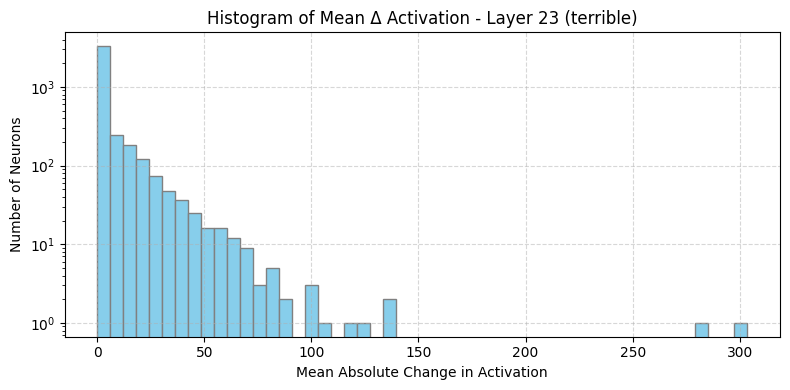

Top neurons for category 'horrible':
  Neuron 3736 -> Δ activation ≈ 243.1
  Neuron 1612 -> Δ activation ≈ 217.3
  Neuron 3367 -> Δ activation ≈ 128.5
  Neuron 2196 -> Δ activation ≈ 112.7
  Neuron 946 -> Δ activation ≈ 100.0
  Neuron 1923 -> Δ activation ≈ 97.6
  Neuron 2560 -> Δ activation ≈ 96.2
  Neuron 5 -> Δ activation ≈ 95.7
  Neuron 1589 -> Δ activation ≈ 85.6
  Neuron 1852 -> Δ activation ≈ 82.5
Average Δ activation across all neurons for category 'horrible': 4.6


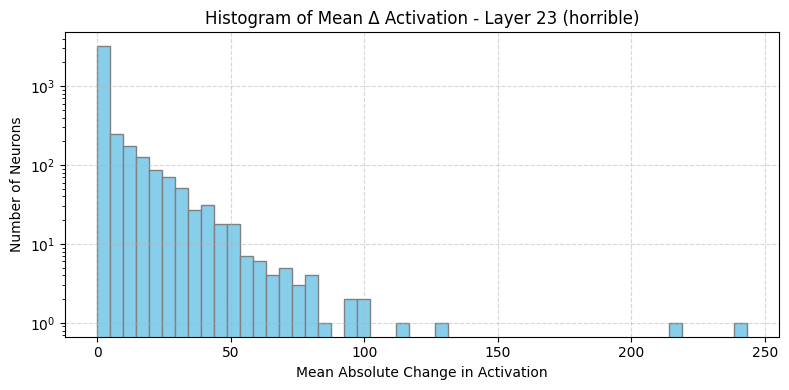

Top neurons for category 'awful':
  Neuron 1612 -> Δ activation ≈ 201.4
  Neuron 3736 -> Δ activation ≈ 193.7
  Neuron 1609 -> Δ activation ≈ 174.1
  Neuron 2560 -> Δ activation ≈ 145.9
  Neuron 2354 -> Δ activation ≈ 133.6
  Neuron 1923 -> Δ activation ≈ 130.6
  Neuron 590 -> Δ activation ≈ 123.9
  Neuron 379 -> Δ activation ≈ 108.3
  Neuron 1564 -> Δ activation ≈ 104.8
  Neuron 1995 -> Δ activation ≈ 103.2
Average Δ activation across all neurons for category 'awful': 5.7


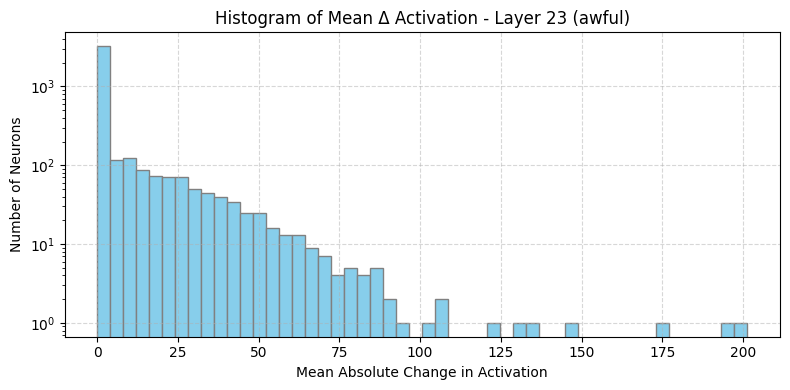

Top neurons for category 'horrific':
  Neuron 3736 -> Δ activation ≈ 302.5
  Neuron 1612 -> Δ activation ≈ 248.3
  Neuron 3367 -> Δ activation ≈ 168.5
  Neuron 946 -> Δ activation ≈ 166.8
  Neuron 961 -> Δ activation ≈ 157.5
  Neuron 3930 -> Δ activation ≈ 129.2
  Neuron 1759 -> Δ activation ≈ 127.6
  Neuron 2196 -> Δ activation ≈ 120.4
  Neuron 2560 -> Δ activation ≈ 115.1
  Neuron 1837 -> Δ activation ≈ 112.9
Average Δ activation across all neurons for category 'horrific': 4.0


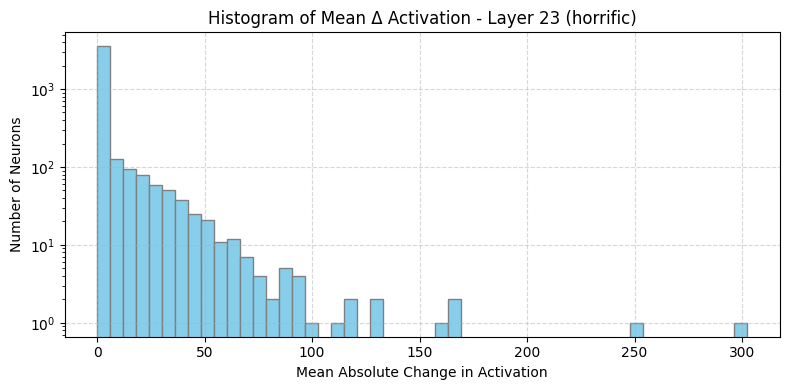

Top neurons for category 'disastrous':
  Neuron 3736 -> Δ activation ≈ 326.5
  Neuron 1612 -> Δ activation ≈ 200.2
  Neuron 1098 -> Δ activation ≈ 191.5
  Neuron 2468 -> Δ activation ≈ 145.7
  Neuron 1609 -> Δ activation ≈ 130.8
  Neuron 2196 -> Δ activation ≈ 124.9
  Neuron 3501 -> Δ activation ≈ 113.5
  Neuron 2142 -> Δ activation ≈ 108.8
  Neuron 2971 -> Δ activation ≈ 95.4
  Neuron 1852 -> Δ activation ≈ 94.2
Average Δ activation across all neurons for category 'disastrous': 3.7


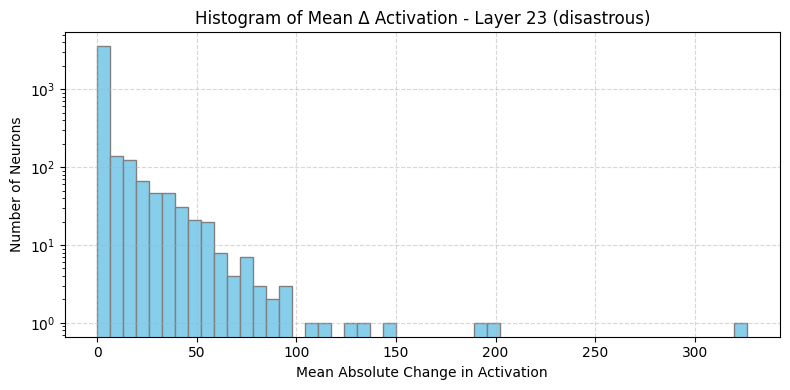

Top neurons for category 'tragic':
  Neuron 3736 -> Δ activation ≈ 233.0
  Neuron 1098 -> Δ activation ≈ 155.0
  Neuron 2560 -> Δ activation ≈ 134.8
  Neuron 1671 -> Δ activation ≈ 132.8
  Neuron 1970 -> Δ activation ≈ 122.4
  Neuron 21 -> Δ activation ≈ 107.3
  Neuron 946 -> Δ activation ≈ 106.0
  Neuron 1759 -> Δ activation ≈ 100.3
  Neuron 4094 -> Δ activation ≈ 97.8
  Neuron 508 -> Δ activation ≈ 97.1
Average Δ activation across all neurons for category 'tragic': 3.6


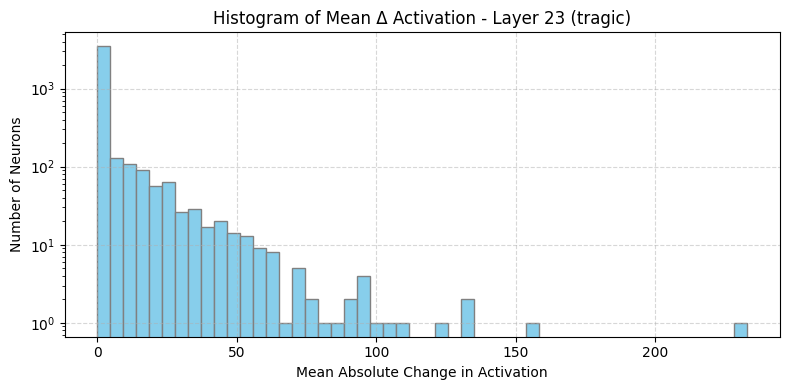

Top neurons for category 'devastating':
  Neuron 3736 -> Δ activation ≈ 134.3
  Neuron 3954 -> Δ activation ≈ 96.2
  Neuron 1608 -> Δ activation ≈ 85.1
  Neuron 3823 -> Δ activation ≈ 83.8
  Neuron 1609 -> Δ activation ≈ 78.3
  Neuron 2870 -> Δ activation ≈ 74.9
  Neuron 3445 -> Δ activation ≈ 72.5
  Neuron 3218 -> Δ activation ≈ 71.5
  Neuron 2411 -> Δ activation ≈ 70.5
  Neuron 5 -> Δ activation ≈ 68.9
Average Δ activation across all neurons for category 'devastating': 3.0


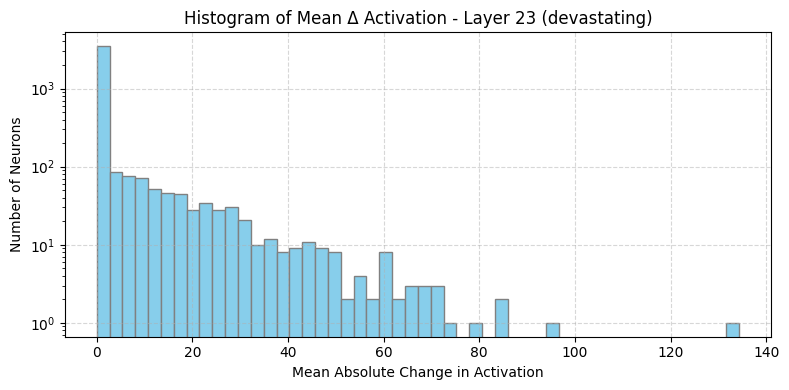

Top neurons for category 'miserable':
  Neuron 1612 -> Δ activation ≈ 230.2
  Neuron 3736 -> Δ activation ≈ 216.4
  Neuron 2652 -> Δ activation ≈ 175.2
  Neuron 2560 -> Δ activation ≈ 155.2
  Neuron 373 -> Δ activation ≈ 130.9
  Neuron 130 -> Δ activation ≈ 127.4
  Neuron 70 -> Δ activation ≈ 120.8
  Neuron 2860 -> Δ activation ≈ 118.8
  Neuron 839 -> Δ activation ≈ 117.2
  Neuron 852 -> Δ activation ≈ 116.9
Average Δ activation across all neurons for category 'miserable': 4.4


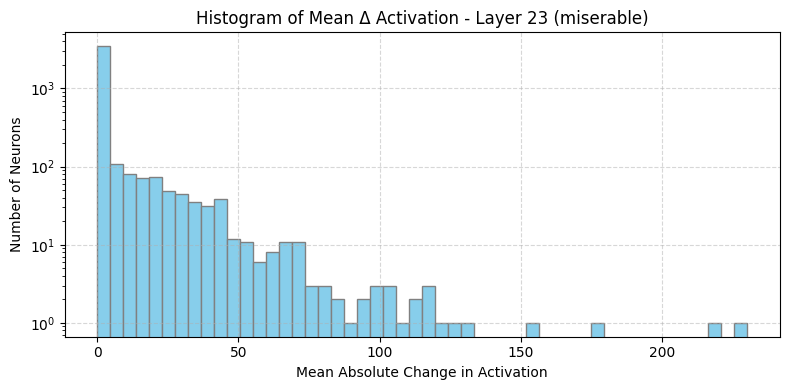

Top neurons for category 'painful':
  Neuron 1612 -> Δ activation ≈ 216.2
  Neuron 4094 -> Δ activation ≈ 149.4
  Neuron 3736 -> Δ activation ≈ 135.5
  Neuron 1589 -> Δ activation ≈ 130.6
  Neuron 109 -> Δ activation ≈ 111.7
  Neuron 3974 -> Δ activation ≈ 111.3
  Neuron 547 -> Δ activation ≈ 103.1
  Neuron 946 -> Δ activation ≈ 101.9
  Neuron 2930 -> Δ activation ≈ 99.9
  Neuron 1607 -> Δ activation ≈ 99.2
Average Δ activation across all neurons for category 'painful': 4.8


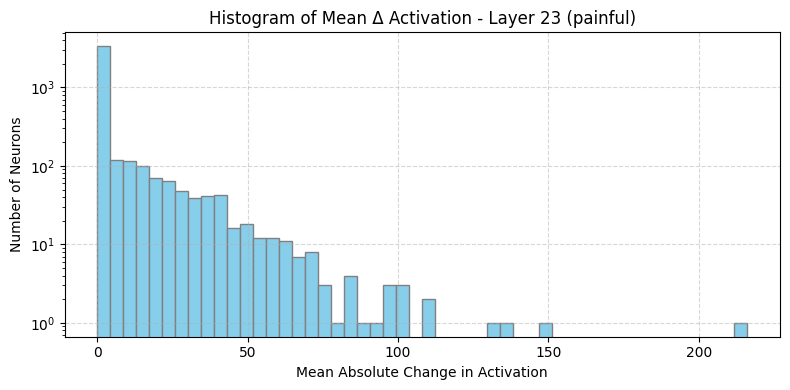

Top neurons for category 'frightening':
  Neuron 1612 -> Δ activation ≈ 170.3
  Neuron 1609 -> Δ activation ≈ 109.5
  Neuron 3717 -> Δ activation ≈ 103.6
  Neuron 175 -> Δ activation ≈ 95.7
  Neuron 547 -> Δ activation ≈ 93.1
  Neuron 2393 -> Δ activation ≈ 91.8
  Neuron 333 -> Δ activation ≈ 88.8
  Neuron 2497 -> Δ activation ≈ 88.6
  Neuron 627 -> Δ activation ≈ 88.4
  Neuron 3736 -> Δ activation ≈ 83.6
Average Δ activation across all neurons for category 'frightening': 3.5


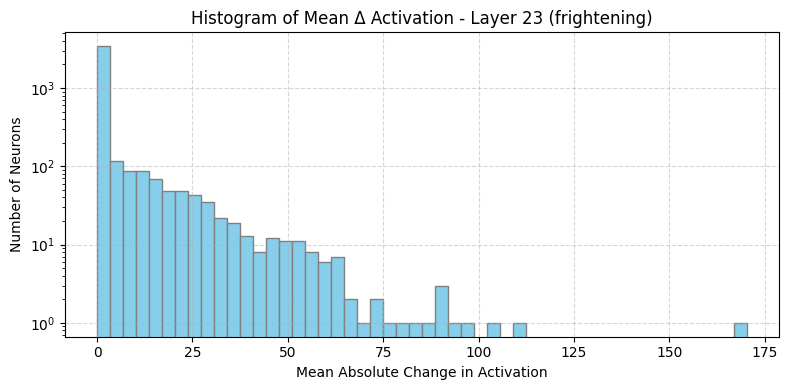

{'terrible': array([ 0.      ,  0.      , 17.994534, ..., 26.761072, 12.389137,
         0.      ], dtype=float32),
 'horrible': array([ 0.       ,  0.       ,  6.1292105, ..., 41.7078   ,  5.3180017,
         2.2741013], dtype=float32),
 'awful': array([ 0.      ,  0.      , 19.248323, ..., 17.949884, 15.093768,
         0.      ], dtype=float32),
 'horrific': array([ 0.      ,  0.      ,  0.      , ..., 28.901764, 26.391745,
         0.      ], dtype=float32),
 'disastrous': array([ 0.      ,  0.      , 24.225845, ..., 23.959528,  0.      ,
         0.      ], dtype=float32),
 'tragic': array([ 0.      ,  0.      ,  0.      , ..., 15.290741, 97.762794,
         0.      ], dtype=float32),
 'devastating': array([ 0.      ,  0.      , 13.313019, ..., 21.472694,  5.24942 ,
         0.      ], dtype=float32),
 'miserable': array([ 0.      , 18.575289,  0.      , ..., 17.310602, 40.135227,
         0.      ], dtype=float32),
 'painful': array([  0.      ,   0.      ,   0.      , ...,  47.2

In [30]:
run_ablation_experiment_vis(model, tokenizer, negative_sentiment_queries, neg_indices, target_layer=23, show_hist=True)